### Tensorflow tutorial and doodling
- This code generously, and shamelessly... borrowed, from: https://www.tensorflow.org/tutorials
- Basic Tensorflow-fu (or is it -foo?)
- Some simple classifiers, regressors, etc. 
- Largely, use this to test TF installations.

The example sets up a simple multi-layer NN to classifiy a standard set of images. The base example uses simple, fully connected layers. We extend this base example to include one or more convolutional layers, which improves both the accuracy and performance consistency (over multiple iterations of the model).

Note for workingon shared resources (aka, tool-servers), it is polite (and consistent with policy) to limit the number of compute cores.


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#

In [2]:
import os
#os.system('source module lcuda/cuda-9.0oad')
import sys

print('ex: ', sys.executable)

ex:  /Users/myoder96/anaconda3/bin/python


In [3]:
#from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy
np = numpy
#import numpy as np
import matplotlib.pyplot as plt

print('TensorFlow version: {}'.format(tf.__version__))
print('TF is_built_with_cuda: ', tf.test.is_built_with_cuda())
print('TF GPU available: {}'.format(tf.test.is_gpu_available()))

TensorFlow version: 1.13.1
TF is_built_with_cuda:  False
TF GPU available: False


In [4]:
import scipy
import pylab as plt
import matplotlib as mpl
import itertools


### Load some image data
- Standard image data set of clothing items

In [5]:
fashion_mnist = keras.datasets.fashion_mnist
#
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()


In [6]:
# We can call these anything, though it is (relatively) important to choose the
#. right number of classes.
#
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [7]:
# Some properties of the data:
print('shapes: ', train_images.shape, train_labels.shape)
print('shapes: ', test_images.shape, test_labels.shape)

shapes:  (60000, 28, 28) (60000,)
shapes:  (10000, 28, 28) (10000,)


In [8]:
# Count objects. numpy.bincount() is probably the bastest way to do this, though it needs to be
#. validadated. Most likely, the values are in sorted order, but we really don't know, right?
#
# numpy.bincount is a nice find:
X = numpy.random.randint(0,3, 25)
print('X :', X)
print('X-counts: \n', numpy.array([numpy.unique(X), numpy.bincount(X)]).T)
#
print('bin_count training: \n', numpy.array([numpy.unique(train_labels), numpy.bincount(train_labels)]).T)
#


X : [1 0 0 1 2 2 0 2 2 1 0 1 0 0 0 2 0 0 2 0 0 2 2 0 1]
X-counts: 
 [[ 0 12]
 [ 1  5]
 [ 2  8]]
bin_count training: 
 [[   0 6000]
 [   1 6000]
 [   2 6000]
 [   3 6000]
 [   4 6000]
 [   5 6000]
 [   6 6000]
 [   7 6000]
 [   8 6000]
 [   9 6000]]


### Plot some of the images, for reference

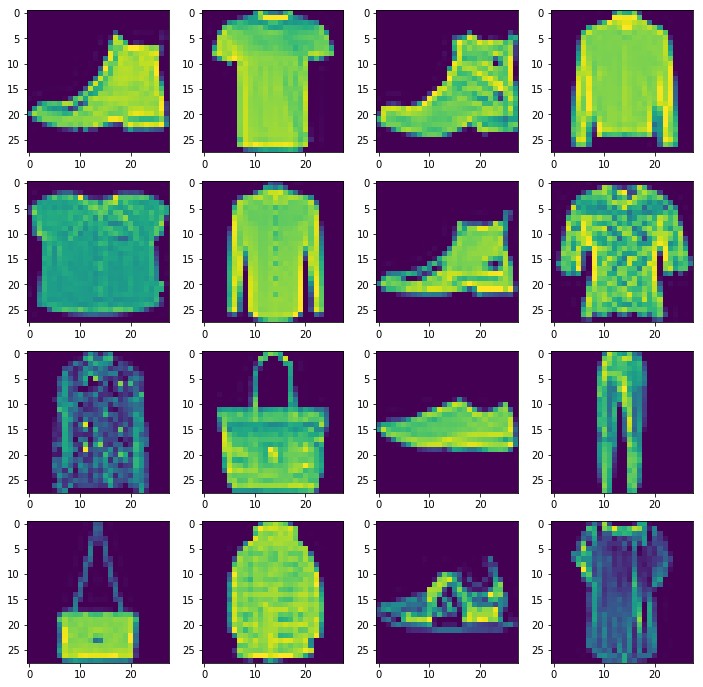

In [9]:
plt.figure(figsize=(12,12))
#
n_col = 4
n_rw  = 4
#
for j,k in itertools.product(range(n_col), range(n_rw)):
    ax = plt.subplot(n_col, n_rw, j*n_rw + k + 1)
    ax.imshow(train_images[numpy.random.randint(len(train_images))])
    #ax.colorbar()
    #
    ax.grid(False)
#plt.show()

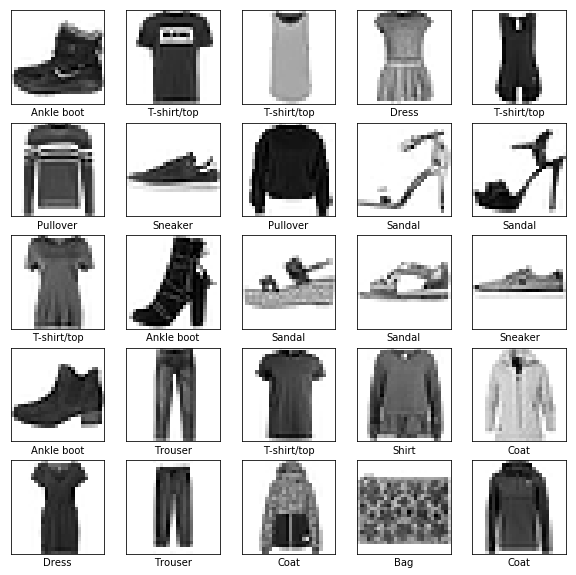

In [10]:
train_images = train_images/255.
test_images  = test_images/255.
#
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

### Do some TensorFlow:
- Enable parallel CPU computation
- Because we might run on shared resrouce, add parameter to limit the resources we will use

- Configure a session
- Build a model
- Train, predict, evaluate

In [11]:
# set up Tensorflow sessin() ???
#. we want to be sensitive to running on the tool servers; do we need to limit the number
#  of cores we use?
n_cpu   = 1
n_cores = 8
#
# sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, 
#                                        log_device_placement=True))
#
# NOTE: the precise configuration might vary a bit. be careful to not give a configuration that 
#.  is incompatible with the hardware and confuses TF (use the Google to better understand how
#.  sensitive TF will be)
# ... and also NOTE: we don't really do anything (yet) with this Session(). I dont' think this
#   step is necessary for our Keras NN.
config = tf.ConfigProto(intra_op_parallelism_threads=n_cores, inter_op_parallelism_threads=n_cores, \
                        allow_soft_placement=True, device_count = {'CPU': n_cpu}, log_device_placement=True)
session = tf.Session(config=config)
#K.set_session(session)
#



In [12]:
# Build the model:
#
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])
#
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
#
model.summary()
#
model.fit(train_images, train_labels, epochs=5)
#
test_loss, test_acc = model.evaluate(test_images, test_labels)
#
print('Test accuracy: {}, Loss: {}'.format(test_acc, test_loss))

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
60000/60000 [==============================] - 3s 43us/sample - loss: 0.4990 - acc: 0.8256
Epoch 2/5
60000/60000 [==============================] - 2s 40us/sample - loss: 0.3738 - acc: 0.8651
Epoch 3/5
60000/60000 [==============================] - 2s 39us/sample - loss: 0.3362 - acc: 0.8777
Epoch 4/5
60000/60000 [==

In [13]:
#
predictions = model.predict(test_images)
#
print('predictions[0]: ', predictions[0])
np.argmax(predictions[0])
#
test_labels[0]


predictions[0]:  [2.1885985e-06 1.8889915e-07 1.6120217e-07 4.0313189e-06 8.5305385e-07
 2.1420734e-03 1.2432148e-05 2.0455075e-02 3.6153073e-05 9.7734684e-01]


9

In [14]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img, cmap=plt.cm.binary)
  
  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

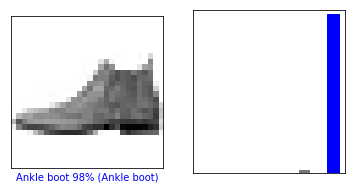

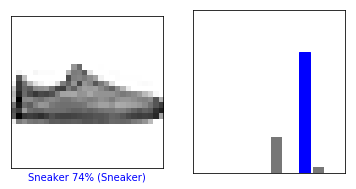

In [15]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)
plt.show()
#
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)
plt.show()

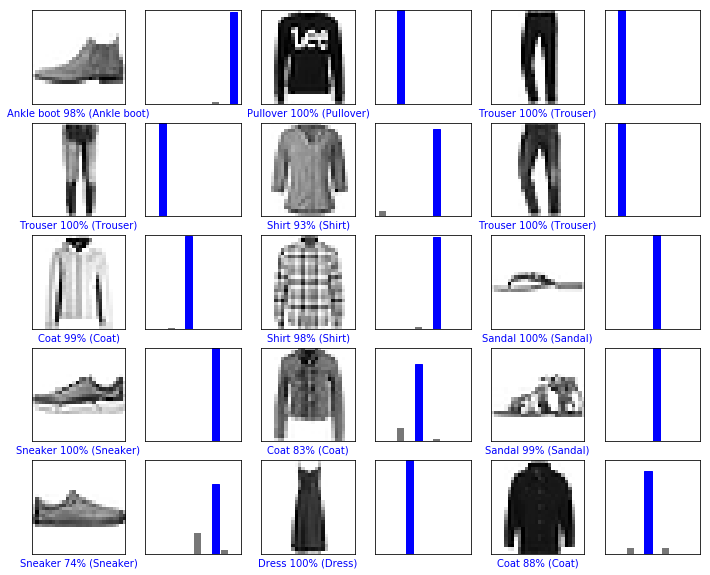

In [16]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)
plt.show()

In [17]:
# In earlier tests on this, TF performance with just fully connected layers was hit and miss.
# Sometimes we'd get 80-90% success; other times much much less, with high variability on
# the success metric.
#
#. Not surprisingly, adding a convolutional layer (or two) significantly improved performance
#. and perormance consistency.
#
# We don't seem to be observing this here, but we want to demonstrate the convolutional layer anyway.
#
# Rebuild the model; add one or more Conv2D layers to the front (is that the top or the bottom?)
# prams: filters: number of filters/components, kernel_size: window size, strides: steps in (x,y),
#.  ... and some others.
#
# reshape images arrays to reflect color channels; in this case, there is one channel.
#. should we be doing this, generally, for the fully-connected layers as well?
#
train_images_conv = train_images.reshape((60000, 28, 28, 1))
test_images_conv  = test_images.reshape((10000, 28, 28, 1))
#
# 
# Build the model:
#
model = keras.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), activation='relu',
                        use_bias=True, dilation_rate=(1,1),
                        input_shape=(28, 28, 1)
                       ),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1,1), activation='relu',
                        use_bias=True, dilation_rate=(1,1)
                       ),
    keras.layers.MaxPooling2D((2, 2)),
    #
    #keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])
#
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
#
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               204928    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total para

In [18]:
#
model.fit(train_images_conv, train_labels, epochs=5)
#
test_loss, test_acc = model.evaluate(test_images_conv, test_labels)
#
print('Test accuracy: {}, Loss: {}'.format(test_acc, test_loss))

Epoch 1/5
60000/60000 [==============================] - 22s 359us/sample - loss: 0.4470 - acc: 0.8379
Epoch 2/5
60000/60000 [==============================] - 22s 360us/sample - loss: 0.2994 - acc: 0.8909
Epoch 3/5
60000/60000 [==============================] - 22s 368us/sample - loss: 0.2563 - acc: 0.9054
Epoch 4/5
60000/60000 [==============================] - 22s 359us/sample - loss: 0.2235 - acc: 0.9167
Epoch 5/5
10000/10000 [==============================] - 1s 85us/sample - loss: 0.2507 - acc: 0.9076
Test accuracy: 0.9075999855995178, Loss: 0.2507235771238804


### GPU Available?
- Is one or more GPU available?
- Also confirm that TF was built with cuda
- And some GPU tutorial from:
    - https://www.tensorflow.org/guide/using_gpu


In [19]:
print('is_built_with_cuda: ', tf.test.is_built_with_cuda())
print(tf.test.is_gpu_available(cuda_only=False) )



is_built_with_cuda:  False
False


#### Executing (not) on a GPU:
This should succeed, with or without a GPU. We can review where the operation was executed:
        sess.ru(c)
from the metadata output.

In [25]:
# Creates a graph.
a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True, allow_soft_placement=True))
# Runs the op.
print('run session: \n', sess.run(c))
#
options = tf.RunOptions(output_partition_graphs=True)
device_meta_data = tf.RunMetadata()
c_vals = sess.run(c, options=options, run_metadata=device_meta_data)

#
print('c_vals: \n', c_vals)
print('meta_data: \n', device_meta_data.partition_graphs)

run session: 
 [[22. 28.]
 [49. 64.]]
c_vals: 
 [[22. 28.]
 [49. 64.]]
meta_data: 
 [node {
  name: "MatMul_5"
  op: "Const"
  device: "/job:localhost/replica:0/task:0/device:CPU:0"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_FLOAT
        tensor_shape {
          dim {
            size: 2
          }
          dim {
            size: 2
          }
        }
        tensor_content: "\000\000\260A\000\000\340A\000\000DB\000\000\200B"
      }
    }
  }
  experimental_debug_info {
    original_node_names: "MatMul_5"
  }
}
node {
  name: "_retval_MatMul_5_0_0"
  op: "_Retval"
  input: "MatMul_5"
  device: "/job:localhost/replica:0/task:0/device:CPU:0"
  attr {
    key: "T"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "index"
    value {
      i: 0
    }
  }
  experimental_debug_info {
    original_node_names: "_retval_MatMul_5_0_0"
  }
}
library {
}
versions {
  producer: 27
}
]


#### Show execution plan:
- This should automatically assign the task to the most capable hardware... or something like that.
- In other words, if there is a GPU available, it should assign the task there; otherwise, it will assign to a cpu.

In [21]:
# Creates a graph.
with tf.device('/cpu:0'):
  a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
  b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
#
# Run the operation and collect/display device meta-data:
#. (in the online TF examples, this is accomplished by simply doing sess.run(c) with
#.  the log_device_placement having been set to True. Notebooks suppresses the output
#.  that we want, so we just have to jump through a few hoops.
options = tf.RunOptions(output_partition_graphs=True)
device_meta_data = tf.RunMetadata()
c_vals = sess.run(c, options=options, run_metadata=device_meta_data)

#
print('c_vals: ', c_vals)
print('meta_data: \n', device_meta_data.partition_graphs)
#
# options = tf.RunOptions(output_partition_graphs=True)
# metadata = tf.RunMetadata()
# c_val = sess.run(c, options=options, run_metadata=metadata)

# print(metadata.partition_graphs)

c_vals:  [[22. 28.]
 [49. 64.]]
meta_data: 
 [node {
  name: "MatMul_1"
  op: "Const"
  device: "/job:localhost/replica:0/task:0/device:CPU:0"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_FLOAT
        tensor_shape {
          dim {
            size: 2
          }
          dim {
            size: 2
          }
        }
        tensor_content: "\000\000\260A\000\000\340A\000\000DB\000\000\200B"
      }
    }
  }
  experimental_debug_info {
    original_node_names: "MatMul_1"
  }
}
node {
  name: "_retval_MatMul_1_0_0"
  op: "_Retval"
  input: "MatMul_1"
  device: "/job:localhost/replica:0/task:0/device:CPU:0"
  attr {
    key: "T"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "index"
    value {
      i: 0
    }
  }
  experimental_debug_info {
    original_node_names: "_retval_MatMul_1_0_0"
  }
}
library {
}
versions {
  producer: 27
}
]


In [22]:
# Creates a graph.
# NOTE: This will fail if there are no GPU devices on the machine.
with tf.device('/device:GPU:0'):
  a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
  b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
#
# Run the operation and collect/display device meta-data:
#. (in the online TF examples, this is accomplished by simply doing sess.run(c) with
#.  the log_device_placement having been set to True. Notebooks suppresses the output
#.  that we want, so we just have to jump through a few hoops.
options = tf.RunOptions(output_partition_graphs=True)
device_meta_data = tf.RunMetadata()
c_vals = sess.run(c, options=options, run_metadata=device_meta_data)

#
print('c_vals: ', c_vals)
print('meta_data: \n', device_meta_data.partition_graphs)
#
# options = tf.RunOptions(output_partition_graphs=True)
# metadata = tf.RunMetadata()
# c_val = sess.run(c, options=options, run_metadata=metadata)

# print(metadata.partition_graphs)

InvalidArgumentError: Cannot assign a device for operation a_2: node a_2 (defined at <ipython-input-22-5af099b9f11a>:4) was explicitly assigned to /device:GPU:0 but available devices are [ /job:localhost/replica:0/task:0/device:CPU:0 ]. Make sure the device specification refers to a valid device. The requested device appears to be a GPU, but CUDA is not enabled.
	 [[node a_2 (defined at <ipython-input-22-5af099b9f11a>:4) ]]

Caused by op 'a_2', defined at:
  File "/Users/myoder96/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/myoder96/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/myoder96/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/myoder96/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/myoder96/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/Users/myoder96/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/Users/myoder96/anaconda3/lib/python3.7/asyncio/base_events.py", line 539, in run_forever
    self._run_once()
  File "/Users/myoder96/anaconda3/lib/python3.7/asyncio/base_events.py", line 1775, in _run_once
    handle._run()
  File "/Users/myoder96/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/Users/myoder96/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/Users/myoder96/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/Users/myoder96/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 781, in inner
    self.run()
  File "/Users/myoder96/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "/Users/myoder96/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 370, in dispatch_queue
    yield self.process_one()
  File "/Users/myoder96/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "/Users/myoder96/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 708, in __init__
    self.run()
  File "/Users/myoder96/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "/Users/myoder96/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/Users/myoder96/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/Users/myoder96/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/Users/myoder96/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/Users/myoder96/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/Users/myoder96/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/Users/myoder96/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/myoder96/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/myoder96/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Users/myoder96/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/Users/myoder96/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/Users/myoder96/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/myoder96/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3214, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/Users/myoder96/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-5af099b9f11a>", line 4, in <module>
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
  File "/Users/myoder96/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/constant_op.py", line 179, in constant_v1
    allow_broadcast=False)
  File "/Users/myoder96/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/constant_op.py", line 289, in _constant_impl
    name=name).outputs[0]
  File "/Users/myoder96/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/Users/myoder96/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/Users/myoder96/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Cannot assign a device for operation a_2: node a_2 (defined at <ipython-input-22-5af099b9f11a>:4) was explicitly assigned to /device:GPU:0 but available devices are [ /job:localhost/replica:0/task:0/device:CPU:0 ]. Make sure the device specification refers to a valid device. The requested device appears to be a GPU, but CUDA is not enabled.
	 [[node a_2 (defined at <ipython-input-22-5af099b9f11a>:4) ]]


In [ ]:
pwd
